# Image emotion detection

Using the [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset. First download and extract the dataset and place it in the working directory as `fer-2013-dataset`.

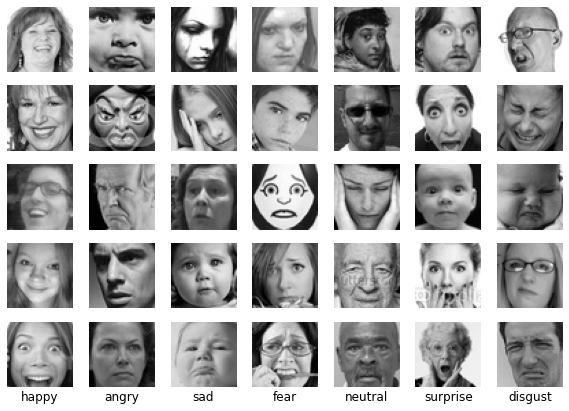

In [67]:
import numpy as np
from pathlib import Path
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# for reproducable results
seed = 123

train_dir = Path("fer-2013-dataset/train")
test_dir = Path("fer-2013-dataset/test")
image_size = (48, 48)
n_classes = sum(1 for _ in train_dir.glob("*"))


plt.figure(figsize=(10, 7))
sample = 5
for (i, emotion) in enumerate(train_dir.glob("*")):
    imgs = emotion.glob("*")
    for n in range(sample):
        img = load_img(emotion.joinpath(next(imgs).name))
        plt.subplot(sample, n_classes, i+1 + n_classes*n)
        plt.imshow(img)
        plt.axis('off')
    plt.title(emotion.name, y=-0.3)
        
plt.show()


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


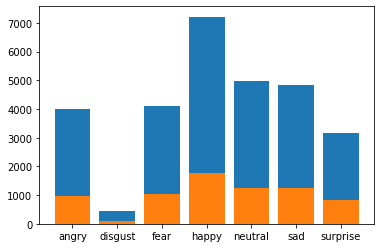

In [68]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

batch_size = 32

train_datagen = ImageDataGenerator(
    # normalize pixels to [0; 1]
    rescale=1/255,
    # will act as a regularizer
    horizontal_flip=True)
train = train_datagen.flow_from_directory(train_dir,
                                          batch_size=batch_size,
                                          target_size=image_size,
                                          shuffle=True,
                                          color_mode='grayscale',
                                          class_mode='categorical',
                                          seed=seed)

test_datagen = ImageDataGenerator(rescale=1/255)
test = test_datagen.flow_from_directory(test_dir,
                                        batch_size=batch_size,
                                        target_size=image_size,
                                        shuffle=True,
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        seed=seed)


def plot_dist(t_set: DirectoryIterator) -> dict[str, int]:
    counts = {
        cl: np.count_nonzero(t_set.classes == i)
        for (cl, i) in t_set.class_indices.items()
    }
    plt.bar(counts.keys(), counts.values())

    return counts


dist1 = plot_dist(train)
dist2 = plot_dist(test)
